# European Derivatives Hedging in Multinomial Market Models

Following [Bachouch et. al](https://arxiv.org/abs/1812.05916v3), consider the example of an investor hedging a European contingent claim $H$ in an arbitrage-free financial market of $d$ risky securities (and a risk-free bank account) and $T$ trading periods until the maturity of $H$.
We identify the securities with their price processes $P^{1},\dots, P^{d}$ which we assume to be non-negative stochastic processes on a probability space $(\Omega, \mathcal{F}, \mathbb{P})$, adapted to a filtration $(\mathcal{G}_t)_{t=0}^T$. 
Write $P_t = (P^{1}_t, \dots, P^{d}_t)$ for all times $t$.
Additionally, $P^{(0)}$ refers to the bank account which at time $t$ shall accrue at the deterministic rate $r_t^{(0)} = \Delta P^{(0)}_t / P^{(0)}_{t-1} \in\mathbb{R}$.

We assume the price processes to have independent increments, meaning that for every risky security $P^i$ the process of its excess returns $(R^i_t)_{t=0}^T$, $$R^{i}_t = \Delta P^{i}_t / P^{i}_{t-1},\quad t=0,\dots, T,$$ as a family of random variables, is independent.
Write $R_t = (R^{1}_t, \dots, R^{d}_t)$ for all times $t$. 

The investor's self-financing hedging strategy reduces to an adapted process $A=(A_0,\dots, A_T)$ with positions $A_t = (A^{1}_t,\dots, A^{d}_t)$ in $\mathbb{R}^d$ indicating the net amounts invested into the market's risky securities at time $t$ together with an *initial wealth* $W_0$:
For the strategy to indeed be self-financing the associated *wealth process* $(W_t)$ given by $W_t=A^{(0)}_t + \sum_{i=1}^d A^{i}_t$, where $A^{(0)}_t$ is the investor's time-$t$ position in the money market account, must satisfy the condition $\Delta W_{t+1} = \langle (A^{(0)}_t,A_t), (r^{(0)}_{t+1}, R_{t+1})\rangle$ at all times $t$ which allows to recurse $$W_{t+1} = W_t + \langle A_t, R_{t+1}\rangle + \bigr(W_t - \sum_{i=1}^d A_t^{i}\bigr)r^{(0)}_{t+1},\quad t=0,\dots, T$$ in terms of the initial wealth $W_0$ and the process $A$.

Let the hedging investor's objective be to expect to incur a minimal *square replication error* $|W_T - H|^2$.
If the claim $H$ is attainable, then the unique initial endowment $W_0^*$ for which the replication error is expected to vanish constitutes the fair price of the claim $H$ at time $0$. 
If the claim is not attainable, then the minimum expected replication error $\varepsilon^*$ is not zero and the unique initial endowment $W_0^*$ producing $\varepsilon^*$ cannot be interpreted as a price.
Rather, $W_0^∗$ may be viewed as the "minimum production cost of replicating the payoff" $H$ to within $\varepsilon^*$ which, depending on their risk preferences, the investor may or may not be willing to pay (not to mention the implications of the a priori use of the square loss function to quantify the replication error) (cf. [Bertsemas et al.](https://doi.org/10.1287/opre.49.3.372.11218) which also includes a discussion of the (un)suitability of the square loss function).

Provided that $H$ is a *simple derivative* such that it factorizes with respect to the terminal market state, i.e., $H=h(P_T)$ for some *payoff function* $h$, we recognize this problem to be a Markovian stochastic optimal control problem as in the scope of ml-adp (compare the [guide](https://ml-adp.readthedocs.io/en/latest/guide.html)).
Because of the independent excess returns, the state relevant to the investor at each time $t$ is limited to the current wealth $w_t$ of their portfolio together with the current market prices $p_t$, that is, $s_t = (w_t, p_t)$. 
The investor controls the next state $s_{t+1}$ through his investments $a_t$ into the risky assets: $S_{T+1}  = F_t(S_t, A_t, R_{t+1})$ with $$F_t(s_t, a_t, r_{t+1}) = \left(w_t + \langle a_t, r_{t+1}\rangle + (w_t - \textstyle\sum_{i=1}^d a_t^i) r^{(0)}_{t+1},\; (1 + r_{t+1}) p_t\right)$$ for $s_t=(w_t,p_t)\in\mathbb{R}^{1+d}$ and $a_t, r_{t+1}\in\mathbb{R}^d$.

Setting $K_0,\dots, K_{T-1}$ to zero and $$K_T(s_T, a_T) = |h(p_T) - w_T|^2$$ we find that an optimal control for a such defined problem evaluates, in the investor's context, to a cost-optimal replication strategy. 
See [Schweizer](https://doi.org/10.1287/moor.20.1.1) for sufficient conditions for an optimal control to exist.



## Imports

In [1]:
from ml_adp import CostAccumulation

Additional packages we will touch:

In [164]:
import torch  # Fundamental
from torch import Tensor
import torch.nn.functional as F
from einops import einsum, rearrange
import matplotlib.pyplot as plt  # Plotting
import copy  # Compare different algorithms starting with equal initial models
from tqdm import tqdm  # Progress bars for the optimization loops

## Device Settings

Enable GPU acceleration of the numerical simulation, if available.

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Model Implementation

Concretely, take

* the financial market to have six trading periods and consist of a single risky asset trading at an initial level of $100$: $T=5$, $d=1$ and $P_0 = 100$ (setting $P=P^{1}$ and $R=R^{1}$)
* A multinomial model for the securities returns: $R_0,\dots, R_T$ i.i.d. with law $$\mathbb{P}_{R_t} = 3/10*\delta_{\{-0.05\}} + 1/10*\delta_{\{0\}} + 6/10 * \delta_{\{0.05\}}$$
* The locally risk-free asset yielding nothing: $R_t^{(0)} = 0$ for all times $t$
* $H$ a European call option on $S$ with maturity $T=5$ and strike equal to the initial price of $S$: $$H = (P_5 - 100)^+$$ such that $H=h(P_T)$ with $h(p_T) = (p_T - 100)$.

Fix the basic parameters:

In [4]:
periods = 6
number_risky_assets = 1

initial_value = torch.tensor(100., device=device)
risk_free_rate = torch.tensor(0., device=device)

rets = torch.tensor([0.05, -0.05, 0.0], device=device)
probs = torch.tensor([0.6, 0.3, 0.1], device=device)

We begin by creating an empty `CostToGo` of appropriate length:

In [5]:
steps = periods - 1
square_replication_error = CostAccumulation.from_steps(steps)

Inspect it:

In [6]:
square_replication_error

CostAccumulation(
 time |      state_func       |     control_func      |       cost_func      
   0  |                       |         None          |         None         
   1  |         None          |         None          |         None         
   2  |         None          |         None          |         None         
   3  |         None          |         None          |         None         
   4  |         None          |         None          |         None         
   5  |         None          |         None          |         None         
  (6) |         None          |                       |                      
)

We will first provide `square_replication_error` with the correct state functions and cost functions (before thinking about a control function architecture).
We begin by implementing the state transition function $F(s_t, a_t, \xi_{t+1})$ (and will need to be mindful of the batch axis while doing so).
We base the implementation on a callable class and have it save the risk-free rate $r^{(0)}$ as an instance attribute.

In [128]:
class MarketStep:
    def __init__(self, risk_free_rate: float = 0.0) -> None:
        self.risk_free_rate = risk_free_rate
    
    def __call__(self, wealth: Tensor, prices: Tensor, positions: Tensor, returns: Tensor) -> Tensor:
        net_amount = positions.sum(dim=-1, keepdim=True)
        bank_account = wealth - net_amount

        change_w = bank_account * self.risk_free_rate + einsum(positions, returns, '... j, ... j-> ...').unsqueeze(-1)
        change_p = prices * returns

        return {'wealth': wealth + change_w, 'prices': prices + change_p}

In [126]:
torch.einsum('... i, ... i -> ... s', torch.tensor([1., 2., 3.]), torch.tensor([4., 5., 6.]))

RuntimeError: einsum(): output subscript s does not appear in the equation for any input operand

Provide `square_replication_error` with `MarketStep`'s:

In [129]:
square_replication_error.state_functions[:-1] = MarketStep(risk_free_rate)

Inspect it:

In [130]:
square_replication_error

CostAccumulation(
 time |      state_func       |     control_func      |       cost_func      
   0  |                       | LinearStrategy(   ... |         None         
   1  | <__main__.MarketS...> | LinearStrategy(   ... |         None         
   2  | <__main__.MarketS...> | LinearStrategy(   ... |         None         
   3  | <__main__.MarketS...> | LinearStrategy(   ... |         None         
   4  | <__main__.MarketS...> | LinearStrategy(   ... |         None         
   5  | <__main__.MarketS...> |         None          | <__main__.SquareR...>
  (6) |         None          |                       |                      
)

Next, implement the cost function $K_T(s_T, a_T) = \vert h(p_T) - w_T\vert^2$.
We modularize the design and consider the payoff function $h$ as a separate component, turning first to the actual square error cost function implementation that will wrap the payoff function, provide it with the market prices when given the state and position argument, and square the its output before finally returning it:

In [131]:
from abc import abstractmethod
from collections.abc import Callable

class Derivative(Callable):
    r"""Implements Payoff Functions $h(p_T)$"""
    @abstractmethod
    def __call__(self, prices: Tensor) -> Tensor:
        return


class SquareReplicationError:
    r"""Given Payoff Function $h(p_T)$, Implements Square Replication Error $|w_T - h(p_T)|^2"""
    def __init__(self, derivative: Derivative) -> None:
        self.derivative = derivative
    
    def __call__(self, wealth: Tensor, prices: Tensor, **dump) -> Tensor:
        payoff = self.derivative(prices)
        return (payoff - wealth).square()

Next, we implement a generic European call option payoff function $h(p_T) = (p_T - K)^+$ which we will instantiate with our example's values:

In [132]:
class EuropeanCallOption(Derivative):
    def __init__(self, strike: float, underlying_index: int) -> None:
        self.strike = strike
        self.underlying_index = underlying_index
    
    def __call__(self, prices: Tensor) -> Tensor:
        underlying_price = prices[..., [self.underlying_index]]
        option_payoff = F.relu(underlying_price - self.strike)
        
        return option_payoff

In [133]:
option = EuropeanCallOption(strike=100., underlying_index=0)

Finally, set the cost function:

In [134]:
square_replication_error.cost_functions[-1] = SquareReplicationError(option)

The user can find the classes `MarketStep`, `Derivative`, `SquareReplicationError` and `EuropeanCallOption`, whose definitions we just printed in full, in the submodule `ml_adp.model.finance`.

Inspect the `square_replication_error`. 
At this point, it is only missing some neural network based control functions.

In [135]:
square_replication_error

CostAccumulation(
 time |      state_func       |     control_func      |       cost_func      
   0  |                       | LinearStrategy(   ... |         None         
   1  | <__main__.MarketS...> | LinearStrategy(   ... |         None         
   2  | <__main__.MarketS...> | LinearStrategy(   ... |         None         
   3  | <__main__.MarketS...> | LinearStrategy(   ... |         None         
   4  | <__main__.MarketS...> | LinearStrategy(   ... |         None         
   5  | <__main__.MarketS...> |         None          | <__main__.SquareR...>
  (6) |         None          |                       |                      
)

Last, but not least, we need to implement a sampler for the random effects which, in the present case, are the excess returns which are i.i.d. with multinomial law given by `rets` and `probs`.
We thus expose the sampling method in terms of the sample size and the number of market steps we want to sample the excess returns for.
Additionally, we include some integration methods we will need later on when implementing the analytic solution of the problem.

In [191]:
from torch.distributions.categorical import Categorical
import functools


class MultinomialDistribution:
    def __init__(self, rets: Tensor, probs: Tensor):
        self.rets = rets
        self.probs = probs
        self.categorical = Categorical(probs)
    
    def __repr__(self):
        return "MultinomialDistribution(" + "+ ".join([f"{prob: .2f}×δ{{{ret : 1.2g}}} " for ret, prob in zip(self.rets, self.probs)]) + ")"
    
    def sample(self, size: torch.Size) -> Tensor:
        return self.rets[self.categorical.sample(size)]
        
    def integrate(self, integrand: Tensor, moment: int = 0):
        return torch.sum(integrand.squeeze(-1) * (self.rets ** moment) * self.probs, dim=-1, keepdim=True)
   
    @functools.cached_property
    def mean(self):
        return self.integrate(torch.tensor(1.), moment=1)
    
    @functools.cached_property
    def second(self):
        return self.integrate(torch.tensor(1.), moment=2)

Instantiate the sampler:

In [192]:
md = MultinomialDistribution(rets, probs)
md

MultinomialDistribution( 0.60×δ{ 0.05} +  0.30×δ{-0.05} +  0.10×δ{ 0} )

## Implementation of the Analytic Solution

For benchmarking purposes, we create another `CostToGo` based on the analytical solution of the problem.
The time-$t$ cost-to-go, as per the analytical solution given in [arXiv:1812.05916v3](https://arxiv.org/abs/1812.05916v3) and derived in [Bertsemas et al.](https://doi.org/10.1287/opre.49.3.372.11218), is $$V_t(s) = K_t w^2 + 2B_t(p)w + C_t(p), \quad s=(w, p)\in\mathbb{R}\times\mathbb{R}$$ where, backward-recursively, with $m_{1, t} = ER_t$ and $m_{2, t} = E(R_t^2)$, $$K_t = K_{t+1}(1 - ER_{t+1}E(R^2_{t+1})),\quad t=T-1,\dots, 0$$ and $$B_t(p) = EB_{t+1}(p(1 + R_{t+1})) - \frac{m_{1,t+1}}{m_{2, t+1}} E(B_{t+1}(p(1+R_{t+1}))R_{t+1}), \quad p\in\mathbb{R},\quad t=T-1,\dots, 0$$ and $$C_t(p) = EC_{t+1}(p(1 + R_{t+1})) - \frac{\bigr(E\big(B_{t+1}(p(1+R_{t+1}))R_{t+1}\big)\bigr)^2}{K_{t+1}\, m_{2,t+1}} ,\quad p\in\mathbb{R}, \quad t=T-1,\dots, 0,$$ based on $$K_T = 1, \quad B_T = h,\quad C_T = h^2.$$

Accordingly:

In [200]:
@functools.cache
def K(time: int, time_horizon: int, md: MultinomialDistribution) -> Tensor:
    return (1. - (md.mean / md.second) * md.mean) ** (time_horizon - time)

@functools.cache
def B(prices: Tensor, time: int, time_horizon: int, option: Derivative, md: MultinomialDistribution) -> Tensor:
    if time == time_horizon:
        return option(prices)
    else:
        next_prices = (prices * (1. + md.rets.unsqueeze(0))).unsqueeze(-1)
        b0 = md.integrate(B(next_prices, time+1, time_horizon, option, md), moment=0)
        b1 = md.integrate(B(next_prices, time+1, time_horizon, option, md), moment=1)
        return b0 - (md.mean * b1) / md.second

@functools.cache
def C(prices: Tensor, time: int, time_horizon: int, option: Derivative, md: MultinomialDistribution) -> Tensor:
    if time == time_horizon:
        return option(prices) ** 2
    else:
        next_prices = (prices * (1. + md.rets.unsqueeze(0))).unsqueeze(-1)
        c0 = md.integrate(C(next_prices, time+1, time_horizon, option, md), moment=0)
        b1 = md.integrate(B(next_prices, time+1, time_horizon, option, md), moment=1)
        return c0 - (b1 / K(time+1, time_horizon, md)) * (b1 / md.second)

In [201]:
import functools as ft

k = ft.partial(K, time=0, time_horizon=periods, md=md)
b = ft.partial(B, time=0, time_horizon=periods, option=option, md=md)
c = ft.partial(C, time=0, time_horizon=periods, option=option, md=md)

def v0(wealth: Tensor, prices: Tensor):
    return k() * (wealth ** 2) - 2 * b(prices) * wealth + c(prices)

analytic_error = CostAccumulation.from_steps(0)
analytic_error.cost_functions[0] = v0

Inspect the analytic solution for different initial price values; the location $W_0^* = B_0(p_0)/K_0$ of the global minimum $\varepsilon^* = 0$ of the cost-to-go graphs represents the fair price of the attainable derivative at time $0$.
In our example, at the given initial price value of $100$, the price of the given European call option evaluates to:

In [202]:
b(initial_value) / k()

tensor([[4.6183]])

The following plots show how the initial price level affects the replication costs:

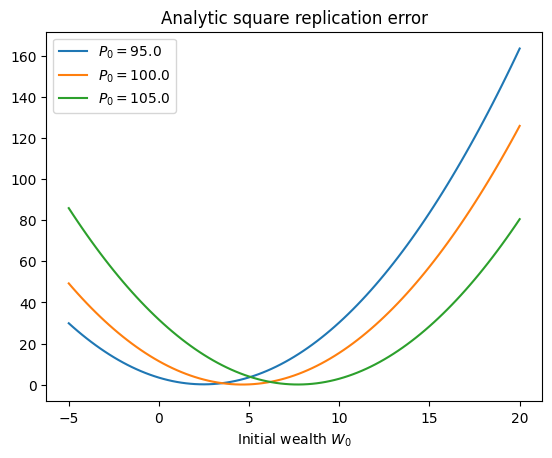

In [217]:
initial_wealths = torch.arange(-5., 20.25, 0.25).unsqueeze(-1)
benchmark_market_prices = torch.tensor([[95.], [100.], [105.]])

analytic_errors = []

plt.title("Analytic square replication error")
plt.xlabel("Initial wealth $W_0$")

for market_prices in benchmark_market_prices:
    replication_costs = [float(v0(initial_wealth, market_prices)) for initial_wealth in initial_wealths]
    plt.plot(initial_wealths, replication_costs, label=f"$P_0 = {float(market_prices)}$")

plt.legend()
plt.show()

## Control Function Specification

We are finally reached the point where the neural networks to be used for the control functions must be specified.
This, generally, is an exercise of the domain expert.
A such will be informed (by e.g. [arXiv:1812.05916v3](https://arxiv.org/abs/1812.05916v3)) that, in the given situation, the optimal control at each step will depend linearly on the current wealth level and that the current market price levels parametrize these linear dependencies.
`ml_adp.mapping.linear.LinearMap` implements learnable such parametrized linear maps by relying on an FFN to parametrize a linear transformation representation matrix.


In [218]:
from ml_adp.utils.fnn import FNN
from typing import Sequence
from einops import einsum


class LinearStrategy(torch.nn.Module):
    """
    Have an FFN parametrize a linear insertion (of the wealth 
    into the control space) with (d x 1)-representation matrix 
    """
    def __init__(self, hidden_layer_sizes: Sequence[int], **ffn_config):
        super().__init__()
        ffn_config.update({
            'size': (number_risky_assets, *hidden_layer_sizes, (number_risky_assets, 2)),
            'hidden_activation': 'ELU'
        })
        self.fnn = FNN.from_config(**ffn_config)

    def forward(self, wealth: Tensor, prices: Tensor) -> Tensor:
        weight, bias = self.fnn(prices).split([1, 1], dim=-1)
        positions = einsum(weight, wealth, '... i j, ... j -> ... i') + bias.squeeze(-1)

        return {'positions': positions}

Set the control functions; the following configuration has been identified to work well for the controls of this particular instance of the option hedging problem:

In [219]:
hidden_layer_sizes = (60, 60)

for time in range(len(square_replication_error) - 1):  # Do not need a control at maturity
    square_replication_error.control_functions[time] = LinearStrategy(hidden_layer_sizes)

Inspect ``square_replication_error`` and sanity-check its representation:

In [220]:
square_replication_error

CostAccumulation(
 time |      state_func       |     control_func      |       cost_func      
   0  |                       | LinearStrategy(   ... |         None         
   1  | <__main__.MarketS...> | LinearStrategy(   ... |         None         
   2  | <__main__.MarketS...> | LinearStrategy(   ... |         None         
   3  | <__main__.MarketS...> | LinearStrategy(   ... |         None         
   4  | <__main__.MarketS...> | LinearStrategy(   ... |         None         
   5  | <__main__.MarketS...> |         None          | <__main__.SquareR...>
  (6) |         None          |                       |                      
)

## Choosing the Training Distributions

For the training distributions, the domain expert defaults to a normal distribution that for the wealths has ~ 68% of its mass contained in the interval $[0, 10]$ and is centered at $5$ (which is a reasonable estimate for the price of the option) and chooses, for the prices, again a normal distribution centered at the initial price $100$ and with the standard deviation increasing based on the number of trading periods into the market (reflecting his expectation of the distribution of the prices to get flatter with time).

In [221]:
from torch.distributions.normal import Normal
from torch.distributions.log_normal import LogNormal


class TrainingStateSampler:
    def __init__(self, time: int, sim_size: int):
        
        self.sim_size = sim_size
        self.wealth_sampler = Normal(torch.tensor(5., device=device), torch.tensor(10., device=device))
      
        scale = max(time, 1) / 10
        loc = initial_value.log() - scale ** 2 / 2
        self.price_sampler = LogNormal(loc, torch.tensor(scale, device=device))
   
    def sample(self) -> Tensor:
        state = {
            'wealth': self.wealth_sampler.sample((self.sim_size, 1)),
            'prices': self.price_sampler.sample((self.sim_size, number_risky_assets))
        }
        return state


class RandomEffectsSampler:
    def __init__(self, sim_size: int):
        self.sim_size = sim_size
        self.returns_sampler = md

    def sample(self, steps: int) -> Tensor:
        return [{'returns': self.returns_sampler.sample((self.sim_size, number_risky_assets))} 
                 for _ in range(steps)]

Create a dictionary containing all the relevant components:

In [222]:
model = {
    'cost_to_go': square_replication_error,
    'training_state_samplers': [TrainingStateSampler(time) for time in range(len(square_replication_error))],
    'random_effects_samplers': len(square_replication_error) * [md]
}

TypeError: TrainingStateSampler.__init__() missing 1 required positional argument: 'sim_size'

## NNContPI

Create a fresh copy of the model and extract the components:

In [147]:
model = copy.deepcopy(model)

cost_to_go = model['cost_to_go']
training_state_samplers = model['training_state_samplers']
random_effects_samplers = model['random_effects_samplers']


NameError: name 'model' is not defined

The following optimization hyperparameters work well:

In [223]:
gradient_descent_steps = 350 

optimizer_class = torch.optim.AdamW
lr = 0.03

scheduler_class = torch.optim.lr_scheduler.ExponentialLR
gamma = 0.75

Choose the sample size for the Monte-Carlo simulation:

In [224]:
sim_size = 5000

In [225]:
cost_to_go = square_replication_error

Perform the NNContPi optimization routine:

In [226]:
print("Optimizing the following model using NNContPi-Algorithm:")
print(cost_to_go.__repr__())

cost_to_go.train()

for time in reversed(range(len(cost_to_go) - 1)):
    
    objective = cost_to_go[time:]
    training_state_sampler = TrainingStateSampler(time, sim_size)
    random_effects_sampler = RandomEffectsSampler(sim_size)
    #training_state_sampler = training_state_samplers[time]
    #random_effects_sampler = random_effects_samplers[time]

    optimizer = optimizer_class(objective.control_functions[0].parameters(), lr=lr)
    scheduler = scheduler_class(optimizer, gamma=gamma)

    gradient_descent_iterations = tqdm(range(gradient_descent_steps), ascii=' =')
    for iteration in gradient_descent_iterations:

        training_state = training_state_sampler.sample()
        random_effects = random_effects_sampler.sample(objective.steps())

        cost = objective(training_state, random_effects).mean()
        
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        #if iteration % 30 == 0 and iteration > 0:
        #    scheduler.step()

        gradient_descent_iterations.set_description(
            f"Time {time} Ctrl. Opt. - `cost_to_go[{time}:]`-Cost: {cost:9.4f}"
        )
    
    objective.eval()

Optimizing the following model using NNContPi-Algorithm:
CostAccumulation(
 time |      state_func       |     control_func      |       cost_func      
   0  |                       | LinearStrategy(   ... |         None         
   1  | <__main__.MarketS...> | LinearStrategy(   ... |         None         
   2  | <__main__.MarketS...> | LinearStrategy(   ... |         None         
   3  | <__main__.MarketS...> | LinearStrategy(   ... |         None         
   4  | <__main__.MarketS...> | LinearStrategy(   ... |         None         
   5  | <__main__.MarketS...> |         None          | <__main__.SquareR...>
  (6) |         None          |                       |                      
)


Time 4 Ctrl. Opt. - `cost_to_go[4:]`-Cost: 1186.1788:   0%|          | 0/350 [00:00<?, ?it/s]

Time 4 Ctrl. Opt. - `cost_to_go[4:]`-Cost:  992.5614:  81%|========  | 284/350 [00:11<00:02, 25.66it/s]


KeyboardInterrupt: 

Note that the time required for each gadient descent iteration increases as the backward pass advances.

Plot the expected square replication errors as implied by `cost_to_go` and the analytical solution against the initial wealth.

In [227]:
training_state['wealth'].size()

torch.Size([5000, 1])

In [228]:
objective(training_state, random_effects).size()

torch.Size([5000, 1])

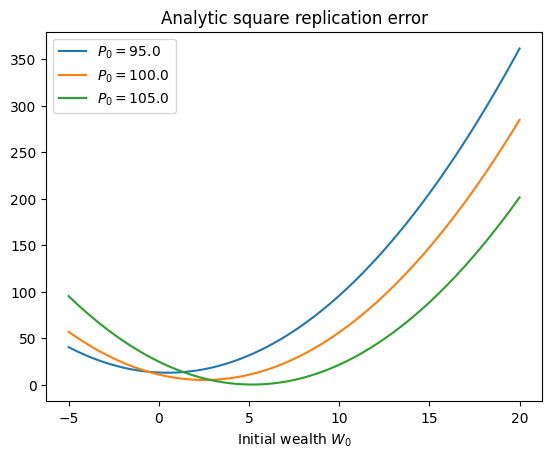

In [231]:
initial_wealths = torch.arange(-5., 20.25, 0.25).unsqueeze(-1)
benchmark_market_prices = torch.tensor([[95.], [100.], [105.]])

analytic_errors = []

plt.title("Analytic square replication error")
plt.xlabel("Initial wealth $W_0$")

nn_replication_costs = []

objective.eval()

for market_prices in benchmark_market_prices:
    replication_costs = []
    
    for initial_wealth in initial_wealths:
        state = {'wealth': initial_wealth.unsqueeze(0), 'prices': market_prices.unsqueeze(0)}
        replication_costs.append(float(objective(state, random_effects).mean()))

    plt.plot(initial_wealths, replication_costs, label=f"$P_0 = {float(market_prices)}$")

plt.legend()
plt.show()

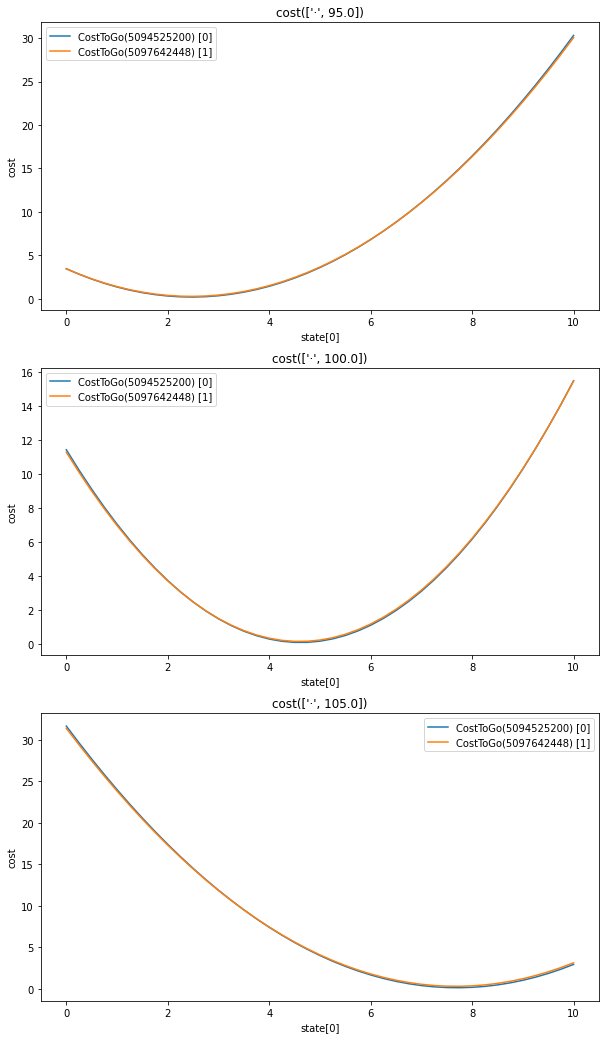

In [30]:
rand_effs = random_effects_samplers[-1].sample(10000, cost_to_go.number_of_steps())

analytic_error.plot_integral_functional(
    torch.arange(0, 10.25, 0.25).to(device),
    torch.arange(95., 105.5, 5.).to(device), 
    random_effects=rand_effs,
    versus=cost_to_go,
    plot_size=(10, 6)
)
plt.show()

Approximately infer from the orange line the fair price of $4.6$ (for the initial price of $100$) for the option and compare the analytical solution (in blue).